## <a id='0'>Contents </a>

- <a href='#0'>Contents</a>
- <a href='#1'>1.Import Packages</a>
- <a href='#2'>2.Set Root Directory </a>
- <a href='#3'>3.Read Data file(s)</a>
- <a href='#4'>4.Data OverView</a>
    - <a href='#4.1'>4.1 Adding Additional Columns </a>
- <a href='#5'>5.Creating DFTrain, DFVal and DFTest </a>
- <a href='#6'>6. Column Selectors </a>
    - <a href='#6-1'>6.1 Custom Transformers for ShirtSizing</a>
    - <a href='#6-2'>6.2 Pipeline for ShirtSizing </a>
    - <a href='#6-3'>6.3 Custom Transformers for MeanEncoding </a>
    - <a href='#6-4'>6.4 Pipelines for MeanEncoding </a>
- <a href='#7'>7. ML Model </a>
- <a href='#8'>8. Predictions </a>

# <a id='1'>1. Import the required packages </a>

#### <a href='#0'>Go To TOp</a>

In [84]:
import os
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import pandas_profiling
import matplotlib.pyplot as plt
from datetime import datetime, date
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, log_loss, roc_curve,f1_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder,StandardScaler,LabelBinarizer, OneHotEncoder

%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# <a id='2'> 2. Setting up Folder Paths </a>
#### <a href='#0'>Go To TOp</a>

In [2]:
# This variable should be the only one that requires adjustment on each developer's machine

PROJECT_ROOT_FOLDER = 'C:/Users/Kishan/Desktop/SupplyChain-SAP/'

# ----------------------------------------------------------------
# These variables shouldn't have to be updated on each dev machine
RAW_DATA_FOLDER       = PROJECT_ROOT_FOLDER + 'data/rawdata/'
PROCESSED_DATA_FOLDER = PROJECT_ROOT_FOLDER + 'data/processeddata/'
OUTPUT_FOLDER         = PROJECT_ROOT_FOLDER + 'output/'

#SPRINT_DATA_FOLDER    = PROCESSED_DATA_FOLDER + 'sprint1/'
#SPRINT_OUTPUT_FOLDER  = OUTPUT_FOLDER + 'sprint1/'

####  Ensure that the paths exist in the local environment

In [3]:
# quick check-point to make sure all the folders exist locally
assert \
os.path.exists(PROJECT_ROOT_FOLDER)    and \
os.path.exists(RAW_DATA_FOLDER)        and \
os.path.exists(PROCESSED_DATA_FOLDER) #and \
#os.path.exists(SPRINT_DATA_FOLDER)    # and \
#os.path.exists(SPRINT_OUTPUT_FOLDER)

# <a id='3'> 3. Reading Data </a>
#### <a href='#0'>Go To TOp</a>

In [4]:
PROCESSED_DATA_FOLDER

'C:/Users/Kishan/Desktop/SupplyChain-SAP/data/processeddata/'

In [5]:
#Reading Supply Chain file

df = pd.read_csv(PROCESSED_DATA_FOLDER + 'Clean_BaseDataset_order_Gran.csv'
                 #,sep='|'
                 ,encoding = "latin-1"
                # ,error_bad_lines=False
                 ,parse_dates=True
                )

In [6]:
df.shape

(65752, 56)

In [7]:
df.head()

,customer_city,customer_country,customer_email,customer_firstname,customer_id,customer_lastname,customer_password,customer_segment,customer_state,customer_street,customer_zip,type,shipping_days_actual,shipping_days_scheduled,delivery_status,late_delivery_risk,market,order_city,order_country,order_cust_id,order_date,order_id,order_region,order_state,order_zip,shipping_date,shipping_mode,num_days_late,order_status,store_city,store_state,gapbetween_orderandship_date,samecountry_source_dest,weekend_duringshipping,weekend_duringshipping_Scheduleddays,shipping_on_weekends,ordered_on_weekends,shipping_dt_weekday,order_dt_weekday,shipping_dt_weekday_name,order_dt_weekday_name,shipping_dt_year_month,order_dt_year_month,shipping_dt_month,order_dt_month,shipping_dt_year,order_dt_year,store_country,sc_oc,latitude,longitude,order_item_count,item_qty_sum,order_item_productprice_sum,discount_sum,order_item_productprice_after_discount_sum
0,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.00,DEBIT,3,4,Advance shipping,0,Pacific Asia,Bekasi,Indonesia,20755,2018-01-31 22:56:00,77202,Southeast Asia,Java Occidental,nan,2018-02-03 22:56:00,Standard Class,-1,COMPLETE,Caguas,Puerto Rico,3.00,Different Countries,Yes Weekend involved,Yes Weekend involved,ShippedonWeekend,OrderedonWeekday,5,2,Saturday,Wednesday,2018-02,2018-01,2,1,2018,2018,Puerto Rico,Caguas-Bekasi,18.25,-66.04,1,1,327.75,13.11,314.64
1,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.00,TRANSFER,5,4,Late delivery,1,Pacific Asia,Bikaner,India,19492,2018-01-13 12:27:00,75939,South Asia,RajastÃÂÃÂÃÂÃÂ¡n,nan,2018-01-18 12:27:00,Standard Class,1,PENDING,Caguas,Puerto Rico,5.00,Different Countries,Yes Weekend involved,Yes Weekend involved,ShippededonWeekday,OrderedonWeekend,3,5,Thursday,Saturday,2018-01,2018-01,1,1,2018,2018,Puerto Rico,Caguas-Bikaner,18.28,-66.04,1,1,327.75,16.39,311.36
2,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.00,CASH,4,4,Shipping on time,0,Pacific Asia,Bikaner,India,19491,2018-01-13 12:06:00,75938,South Asia,RajastÃÂÃÂÃÂÃÂ¡n,nan,2018-01-17 12:06:00,Standard Class,0,CLOSED,San Jose,California,4.00,Different Countries,Yes Weekend involved,Yes Weekend involved,ShippededonWeekday,OrderedonWeekend,2,5,Wednesday,Saturday,2018-01,2018-01,1,1,2018,2018,United States,San Jose-Bikaner,37.29,-121.88,1,1,327.75,18.03,309.72
3,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.00,DEBIT,3,4,Advance shipping,0,Pacific Asia,Townsville,Australia,19490,2018-01-13 11:45:00,75937,Oceania,Queensland,nan,2018-01-16 11:45:00,Standard Class,-1,COMPLETE,Los Angeles,California,3.00,Different Countries,No weekend involved,No weekend involved,ShippededonWeekday,OrderedonWeekend,1,5,Tuesday,Saturday,2018-01,2018-01,1,1,2018,2018,United States,Los Angeles-Townsville,34.13,-118.29,1,1,327.75,22.94,304.81
4,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.00,PAYMENT,2,4,Advance shipping,0,Pacific Asia,Townsville,Australia,19489,2018-01-13 11:24:00,75936,Oceania,Queensland,nan,2018-01-15 11:24:00,Standard Class,-2,PENDING_PAYMENT,Caguas,Puerto Rico,2.00,Different Countries,No weekend involved,No weekend involved,ShippededonWeekday,OrderedonWeekend,0,5,Monday,Saturday,2018-01,2018-01,1,1,2018,2018,Puerto Rico,Caguas-Townsville,18.25,-66.04,1,1,327.75,29.50,298.25


In [8]:
df.columns.tolist()

['customer_city',
 'customer_country',
 'customer_email',
 'customer_firstname',
 'customer_id',
 'customer_lastname',
 'customer_password',
 'customer_segment',
 'customer_state',
 'customer_street',
 'customer_zip',
 'type',
 'shipping_days_actual',
 'shipping_days_scheduled',
 'delivery_status',
 'late_delivery_risk',
 'market',
 'order_city',
 'order_country',
 'order_cust_id',
 'order_date',
 'order_id',
 'order_region',
 'order_state',
 'order_zip',
 'shipping_date',
 'shipping_mode',
 'num_days_late',
 'order_status',
 'store_city',
 'store_state',
 'gapbetween_orderandship_date',
 'samecountry_source_dest',
 'weekend_duringshipping',
 'weekend_duringshipping_Scheduleddays',
 'shipping_on_weekends',
 'ordered_on_weekends',
 'shipping_dt_weekday',
 'order_dt_weekday',
 'shipping_dt_weekday_name',
 'order_dt_weekday_name',
 'shipping_dt_year_month',
 'order_dt_year_month',
 'shipping_dt_month',
 'order_dt_month',
 'shipping_dt_year',
 'order_dt_year',
 'store_country',
 'sc_oc',
 'latitude',
 'longitude',
 'order_item_count',
 'item_qty_sum',
 'order_item_productprice_sum',
 'discount_sum',
 'order_item_productprice_after_discount_sum']

In [9]:
#df['unique_id'] = df['order_id'].map(str)+'-'+df['order_item_id'].map(str)

## <a id='4'>4.Data Type Conversion</a>
<a href='#0'>Go to top </a>

In [10]:
# Converting String columns with date values to Date data type

#df['DOB'] = pd.to_datetime(df['DOB'],errors = 'coerce') 
df['order_date'] = pd.to_datetime(df['order_date'])
df['shipping_date'] = pd.to_datetime(df['shipping_date'])


### <a id='4.1'>4.1 Adding Additional Columns </a>
<a href='#0'>Go to top </a>

In [11]:
#Adding Target Variable. Reducing from multi classification problem to binary classfication

df['late_delivery'] = np.where(df['delivery_status']=='Late delivery',1,0)

#df['sc_oc'] = df['store_city']+"-"+df['order_city']

In [12]:
#df['order_dt_year_month'] = pd.to_datetime(df['order_date']).dt.strftime('%Y-%m')
#df['shipping_dt_year_month'] = pd.to_datetime(df['shipping_date']).dt.strftime('%Y-%m')

#df['order_dt_month'] = df['order_date'].dt.month
#df['order_dt_weekday']=df['order_date'].dt.weekday

#df['shipping_dt_weekday']=df['shipping_date'].dt.weekday
#df['shipping_dt_month'] = df['shipping_date'].dt.month

#df['late_delivery'] = np.where(df['delivery_status']=='Late delivery',1,0)

#df['store_state'].fillna(df['customer_state'], inplace=True)
#df['store_city'].fillna(df['customer_city'], inplace=True)
#df['sc_oc'] = df['store_city']+"-"+df['order_city']

#df['store_country']= np.where(df['store_state']=='Puerto Rico','Puerto Rico','United States')
#df['samecountry_source_dest'] = np.where(df['store_country']==df['order_country'],'SameCountry','DifferentCountry')


#df['gapbetween_order_shipdate'] = (df['shipping_date']-df['order_date'])
#df['gapbetween_order_shipdate']=df['gapbetween_order_shipdate']/np.timedelta64(1,'D')

#df['ordered_on_weekends']= np.where(df['order_dt_weekday'].isin([5,6]),"OrderedonWeekend", "OrderedonWeekday")
#df['shipping_on_weekends']= np.where(df['shipping_dt_weekday'].isin([5,6]),"ShippedonWeekend", "ShippededonWeekday")


#df['weekend_duringshipping']=np.where(((df['shipping_on_weekends']=='ShippedonWeekend')|((df['shipping_dt_weekday']+df['shipping_days_scheduled']-1)>=5)),'Yes Weekend involved','No weekend involved')

In [13]:
cols_notused = [ 'customer_email', 'customer_firstname', 'customer_id',  'customer_lastname', 'customer_password',
                'customer_street','customer_zip', 'late_delivery_risk','order_cust_id', 'order_zip','num_days_late','delivery_status',
                 'order_dt_year_month','shipping_dt_year_month','shipping_days_actual','latitude', 'longitude'
               ]

cols_used =    [  'order_id'
                 ,'late_delivery' 
    
                #Customer Attributes
                 ,'customer_city','customer_segment'
                #,'sc_oc'
                #,'samecountry_source_dest'
                #,'weekend_duringshipping_Scheduleddays'
               
                ,'ordered_on_weekends','shipping_on_weekends'
                 # Not using these columns as they have very less imprtance ,'customer_country', 'customer_segment', 'customer_state'  
    
                 ,'type',  'shipping_days_scheduled',  'market', 'shipping_mode'
                 #,'order_city' ,'store_city'
               # ,'order_status','order_dt_month','shipping_dt_month'
                ,'shipping_dt_weekday','order_dt_weekday'
                # Not suing these columns as they have very less imprtance ,'order_country',  'order_region', 'order_state'
                 
                ##### Increasing the accuracy to 99%
               # ,'gapbetween_orderandship_date'
                
                
]
                


In [14]:
#Adding Target Variable. Reducing from multi classification problem to binary classfication
df_ModelDataSet =df[cols_used]

In [15]:
df_ModelDataSet.shape

(65752, 12)

In [16]:
# Converting String columns with categorical values to Categorical data type

#df['type'] = df['type'].astype('object')

# LoyaltyCustomerFlag is converted to category data type later in the process
#df['LoyaltyCustomerFlag'] = df['LoyaltyCustomerFlag'].astype('category')   

# Converting Float columns with ID values to Object data type
#df['customer_id'] = df['customer_id'].astype('object')
#df['dept_id'] = df['dept_id'].astype('object')
#df['order_cust_id'] = df['order_cust_id'].astype('object')
#df['order_id'] = df['order_id'].astype('object')
#df['order_item_cardprod_id'] = df['order_item_cardprod_id'].astype('object')
#df['order_item_id'] = df['order_item_id'].astype('object')

# <a id='5'> 5.Creating DFTrain, DFVal and DFTest </a>
#### <a href='#0'>Go To TOp</a>

#### Dataset Balancing

In [17]:
#***********************************************************************
#*********** Has to be executed if the dataset has to be balanced ******
#***********************************************************************

#df1 = df_ModelDataSet[df_ModelDataSet['AttritionFlag'] == 0]
#df1 = pd.concat((df1,df_ModelDataSet[df_ModelDataSet['AttritionFlag'] == 1].sample(842089,replace = False)),axis = 0)
#df_ModelDataSet = df1.copy()
#df_ModelDataSet.shape

In [18]:
#Creating a Random Variable to divide the dataset into Train,Val and Test

#df_ModelDataSet['Random'] = np.random.randn(len(df_ModelDataSet['unique_id']), 1)

#Creating TrainVal dataset

#DFTrainval = df_ModelDataSet[df_ModelDataSet['Random']<0.8]

#Creating Train dataset from TrainVal 

#DFTrain = DFTrainval[DFTrainval['Random']<0.6]

#Creating Val dataset from TrainVal 

#DFVal = DFTrainval[~(DFTrainval['Random']<0.6)]

#Creating Test dataset from TrainVal 

#DFTest = df_ModelDataSet[~(df_ModelDataSet['Random']<0.8)]

In [19]:
df_ModelDataSet['late_delivery'].value_counts()

1    36048
0    29704
Name: late_delivery, dtype: int64

In [20]:
df_ModelDataSet.dtypes

order_id                    int64
late_delivery               int32
customer_city              object
customer_segment           object
ordered_on_weekends        object
shipping_on_weekends       object
type                       object
shipping_days_scheduled     int64
market                     object
shipping_mode              object
shipping_dt_weekday         int64
order_dt_weekday            int64
dtype: object

In [21]:
df_ModelDataSet.head()

,order_id,late_delivery,customer_city,customer_segment,ordered_on_weekends,shipping_on_weekends,type,shipping_days_scheduled,market,shipping_mode,shipping_dt_weekday,order_dt_weekday
0,77202,0,Caguas,Consumer,OrderedonWeekday,ShippedonWeekend,DEBIT,4,Pacific Asia,Standard Class,5,2
1,75939,1,Caguas,Consumer,OrderedonWeekend,ShippededonWeekday,TRANSFER,4,Pacific Asia,Standard Class,3,5
2,75938,0,San Jose,Consumer,OrderedonWeekend,ShippededonWeekday,CASH,4,Pacific Asia,Standard Class,2,5
3,75937,0,Los Angeles,Home Office,OrderedonWeekend,ShippededonWeekday,DEBIT,4,Pacific Asia,Standard Class,1,5
4,75936,0,Caguas,Corporate,OrderedonWeekend,ShippededonWeekday,PAYMENT,4,Pacific Asia,Standard Class,0,5


In [22]:
df_ModelDataSet.shape

(65752, 12)

In [23]:
DFTrainVal = df_ModelDataSet.sample(frac =.8) 

In [24]:
DFTrainVal.shape

(52602, 12)

In [25]:
DFTrain = DFTrainVal.sample(frac =.8) 

In [26]:
DFTrain.shape

(42082, 12)

In [27]:
DFVal = DFTrainVal[(~DFTrainVal.order_id.isin(DFTrain.order_id))]

In [28]:
DFVal.shape

(10520, 12)

In [29]:
DFTest=df_ModelDataSet[(~df_ModelDataSet.order_id.isin(DFTrainVal.order_id))]

In [30]:
DFTest.shape

(13150, 12)

In [31]:
len(DFTrain)

42082

In [32]:
DFTrain.head()

,order_id,late_delivery,customer_city,customer_segment,ordered_on_weekends,shipping_on_weekends,type,shipping_days_scheduled,market,shipping_mode,shipping_dt_weekday,order_dt_weekday
12270,1832,0,Caguas,Consumer,OrderedonWeekday,ShippededonWeekday,DEBIT,4,LATAM,Standard Class,4,1
20194,54056,0,Fresno,Consumer,OrderedonWeekday,ShippededonWeekday,PAYMENT,0,LATAM,Same Day,1,1
5879,32834,1,Baltimore,Corporate,OrderedonWeekend,ShippededonWeekday,DEBIT,4,USCA,Standard Class,4,6
8740,18461,0,Caguas,Consumer,OrderedonWeekend,ShippededonWeekday,DEBIT,4,Europe,Standard Class,1,6
13021,74930,1,Caguas,Consumer,OrderedonWeekday,ShippededonWeekday,DEBIT,4,Pacific Asia,Standard Class,3,4


In [33]:
len(DFVal)

10520

In [34]:
DFVal.head()

,order_id,late_delivery,customer_city,customer_segment,ordered_on_weekends,shipping_on_weekends,type,shipping_days_scheduled,market,shipping_mode,shipping_dt_weekday,order_dt_weekday
44285,14838,1,Caguas,Corporate,OrderedonWeekday,ShippededonWeekday,TRANSFER,1,Europe,First Class,4,2
12411,53577,0,Caguas,Consumer,OrderedonWeekday,ShippededonWeekday,DEBIT,4,LATAM,Standard Class,4,1
45378,40883,0,Louisville,Consumer,OrderedonWeekday,ShippededonWeekday,DEBIT,4,USCA,Standard Class,1,4
20084,71202,1,Jackson,Consumer,OrderedonWeekend,ShippededonWeekday,DEBIT,1,Europe,First Class,1,6
63235,26097,0,Roswell,Home Office,OrderedonWeekend,ShippededonWeekday,PAYMENT,4,Pacific Asia,Standard Class,1,5


In [35]:
len(DFTest)

13150

In [36]:
DFTest.head()

,order_id,late_delivery,customer_city,customer_segment,ordered_on_weekends,shipping_on_weekends,type,shipping_days_scheduled,market,shipping_mode,shipping_dt_weekday,order_dt_weekday
1,75939,1,Caguas,Consumer,OrderedonWeekend,ShippededonWeekday,TRANSFER,4,Pacific Asia,Standard Class,3,5
8,75932,1,Caguas,Corporate,OrderedonWeekend,ShippededonWeekday,CASH,2,Pacific Asia,Second Class,1,5
10,75930,0,Caguas,Corporate,OrderedonWeekend,ShippededonWeekday,TRANSFER,2,Pacific Asia,Second Class,4,5
14,75926,1,Peabody,Corporate,OrderedonWeekend,ShippededonWeekday,TRANSFER,1,Pacific Asia,First Class,0,5
32,75908,0,Caguas,Consumer,OrderedonWeekend,ShippededonWeekday,PAYMENT,4,Pacific Asia,Standard Class,2,5


# <a id='6'> 6. Columns Selector </a>
#### <a href='#0'>Go To TOp</a>

In [37]:
#Defining id_col, target_col and Shirtsize_cols

id_col = 'order_id'
target_col = 'late_delivery'

               
#shirtsize_cols = [#'order_item_qty' ,'total_product_price', 'discounted_total_product_price'
                 # ,"Diamondback Boys' Insight 24 Performance Hybr", 'GoPro HERO3+ Black Edition Camera', 'Ogio Race Golf Shoes'
                 #,'Pelican Maverick 100X Kayak', 'SOLE E25 Elliptical', 'Team Golf St. Louis Cardinals Putter Grip'
                 #,'Titleist Club Glove Travel Cover', 'Titleist Small Wheeled Travel Cover', 'Total Gym 1400', 'other_prods'
                # ,'Accessories', 'As Seen on  TV!', 'Cameras ','Fitness Accessories', 'Golf Bags & Carts', 'Lacrosse'
                 #,'Music','Pet Supplies','Strength Training', 'other_cats'
#                 ]


In [38]:
#Custom Transformer that extracts columns passed as argument to its constructor 

class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self._feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self._feature_names ] 

# <a id='6-1'> 6.1 Custom Transformer Shirt Sizing </a>

####  (No Need to execute 6.1 and 6.2 sections, as there are no numerical values to be convetred to categorical values )  
#### <a href='#0'>Go To Top</a>

In [39]:
#Funtions to create bins dynamically 

#cut = []
#settings = {}
#class DFShirtSize(BaseEstimator, TransformerMixin):
#    def __init__(self,columns = None):
#        self.columns = columns # array of column names to encode

#    def fit(self,X,y=None):
#        df = X.copy()
#        if self.columns is not None:
#            for col_name in self.columns:
#                df[col_name] = df[col_name].fillna(0)
#                colmin = (abs(df[col_name].min())+1)
#                cuts = pd.cut(
#                             np.log(colmin + df[col_name]),
#                             bins = 4,
#                             labels=['1_small','2_medium','3_large','4_xlarge',],
#                             retbins = True
#                           )[1]
#                cuts[0], cuts[-1] = -np.inf, np.inf
#                tempsettings = {col_name: cuts}
#                settings.update(tempsettings)
#    def transform(self,X):
#        df = X.copy()
#        for col, cuts in settings.items():
#                #col_name_ss = col + '_ss'
#                df[col] = df[col].fillna(0)
#                df[col] = pd.cut(
#                                            np.log(1 + df[col]),
#                                            bins = cuts,
#                                            labels=['1_small','2_medium','3_large','4_xlarge']      
#                                        )
#       
#        return df
#        
#    def fit_transform(self,X,y=None):
#        return self.fit(X,y).transform(X)
#

# <a id='6-2'>6.2 Pipeline for ShirtSizing </a>
#### <a href='#0'>Go To Top</a>

In [40]:
#SSEncoding = [
#              ('Column Selector',FeatureSelector(shirtsize_cols)),
#              ('Shirt Sizing', DFShirtSize(shirtsize_cols)),
#             ]

In [41]:
#pipe_sse = Pipeline(SSEncoding)

In [42]:
#pipe_sse.fit(DFTrain)

In [43]:
#Transforming the given dataset

#DFTrain_SSE = pipe_sse.transform(DFTrain)

In [44]:
#Transforming the given dataset

#DFVal_SSE =  pipe_sse.transform(DFVal)

In [45]:
#Transforming the given dataset

#DFTest_SSE =  pipe_sse.transform(DFTest)

In [46]:
#Assigning back shirtsized columns to actual datset

#for col in shirtsize_cols:
#    DFTrain[col] = DFTrain_SSE[col]
#    DFVal[col] = DFVal_SSE[col]
 #   DFTest[col] = DFTest_SSE[col]

In [47]:
#DFTrain.head()

In [48]:
#DFVal.head()

In [49]:
#DFTest.head()

# <a id='6-3'> 6.3 Custom Transofmer for Mean Encoding </a>
#### <a href='#0'>Go To Top</a>

In [50]:
#Defining Mean Encoding columns

#mean_enc_cols = DFTrain.drop(columns = [id_col,target_col,'Random']).columns.tolist()
mean_enc_cols = DFTrain.drop(columns = [id_col,target_col]).columns.tolist()
#mean_enc_cols

In [51]:
DFTrain.dtypes

order_id                    int64
late_delivery               int32
customer_city              object
customer_segment           object
ordered_on_weekends        object
shipping_on_weekends       object
type                       object
shipping_days_scheduled     int64
market                     object
shipping_mode              object
shipping_dt_weekday         int64
order_dt_weekday            int64
dtype: object

In [52]:
#Converting to Mean Encoding columns to Category type

for col in mean_enc_cols: 
    if col != target_col:
        DFTrain.loc[:, col] = DFTrain.loc[:, col].astype('category') 
        DFVal.loc[:, col] = DFVal.loc[:, col].astype('category') 
        DFTest.loc[:, col]   =   DFTest.loc[:, col].astype('category')

In [53]:
#Mean Encoding Function

mean_enc_settings = {}
alpha = 5 # (1) can be tuned as a hyper-parameter, (2) can be tuned on a column-by-column basis
prior = 0 
class DFMeanEncoding(BaseEstimator, TransformerMixin):
    def __init__(self,columns = None,df_target_col = None):
        self.columns = columns # array of column names to encode
        self.df_target_col = df_target_col

    def fit(self,X,y=None):
        df = X.copy()
        target_col = 'late_delivery'
        df[target_col] = self.df_target_col
        prior_loc = df[target_col].mean() # global mean for Train fold
        global prior 
        prior = prior_loc
        if self.columns is not None:
            for col in self.columns: #iterate though the columns we want to encode
#                 if col != target_col:
                means     = df.groupby(col)[target_col].mean()
                nrows_cnt = df.groupby(col)[target_col].count()
                means_reg = (means*nrows_cnt + prior*alpha) / (nrows_cnt + alpha)
                mean_enc_settings.update({
                     col: means_reg.to_dict()
                })
        #return self # not relevant here
        
    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        df = X.copy()
        for col, means in mean_enc_settings.items(): #iterate though the columns we want to encode
            df[col] = df[col].map(means).astype(np.float32).fillna(prior)
        return df

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)


In [54]:
MeanEncoding = [
              ('Column Selector',FeatureSelector(mean_enc_cols)),
              ('Mean Encoding', DFMeanEncoding(mean_enc_cols,DFTrain[[target_col]])),
             ]

# <a id='6-4'> 6.4 Pipeline for Mean Encoding </a>
#### <a href='#0'>Go To Top</a>

In [55]:
pipe_me = Pipeline(MeanEncoding)

In [56]:
pipe_me.fit(DFTrain)

Pipeline(memory=None,
         steps=[('Column Selector', FeatureSelector(feature_names=None)),
                ('Mean Encoding',
                 DFMeanEncoding(columns=['customer_city', 'customer_segment',
                                         'ordered_on_weekends',
                                         'shipping_on_weekends', 'type',
                                         'shipping_days_scheduled', 'market',
                                         'shipping_mode', 'shipping_dt_weekday',
                                         'order_dt_weekday'],
                                df_target_col=       late_delivery
12270              0
20194              0
5879               1
8740               0
13021              1
...              ...
11400              0
23986              1
60062              1
8393               0
8268               1

[42082 rows x 1 columns]))],
         verbose=False)

In [57]:
#Transforming the given the dataset

DFTrain_ME = pipe_me.transform(DFTrain)

In [58]:
DFTrain_ME .head()

,customer_city,customer_segment,ordered_on_weekends,shipping_on_weekends,type,shipping_days_scheduled,market,shipping_mode,shipping_dt_weekday,order_dt_weekday
12270,0.55,0.55,0.55,0.55,0.57,0.38,0.54,0.38,0.54,0.55
20194,0.52,0.55,0.55,0.55,0.57,0.46,0.54,0.46,0.55,0.55
5879,0.67,0.55,0.54,0.55,0.57,0.38,0.56,0.38,0.54,0.55
8740,0.55,0.55,0.54,0.55,0.57,0.38,0.55,0.38,0.55,0.55
13021,0.55,0.55,0.55,0.55,0.57,0.38,0.55,0.38,0.55,0.55


In [59]:
DFTrain_ME.dtypes

customer_city              float32
customer_segment           float32
ordered_on_weekends        float32
shipping_on_weekends       float32
type                       float32
shipping_days_scheduled    float32
market                     float32
shipping_mode              float32
shipping_dt_weekday        float32
order_dt_weekday           float32
dtype: object

In [60]:
#Transforming the given the dataset

DFVal_ME = pipe_me.transform(DFVal)

In [61]:
DFVal_ME.dtypes

customer_city              float32
customer_segment           float32
ordered_on_weekends        float32
shipping_on_weekends       float32
type                       float32
shipping_days_scheduled    float32
market                     float32
shipping_mode              float32
shipping_dt_weekday        float32
order_dt_weekday           float32
dtype: object

In [62]:
#Transforming the given the dataset

DFTest_ME = pipe_me.transform(DFTest)

In [63]:
#Assigning back Id Col

DFTrain_ME[id_col]=DFTrain[id_col]
DFVal_ME[id_col]=DFVal[id_col]


DFTrain_ME[target_col]=DFTrain[target_col]
DFVal_ME[target_col]=DFVal[target_col]

DFTest_ME[id_col]=DFTest[id_col]
DFTest_ME[target_col]=DFTest[target_col]

                           

In [64]:
#Creating a copy of Train, Val and Test

df_train = DFTrain_ME.drop(columns = id_col).copy()
df_val   =  DFVal_ME.drop(columns = id_col).copy()
df_test =  DFTest_ME.drop(columns = id_col).copy()

In [65]:
#Creating X and y for Train, Val and Test

X_train = df_train.drop(columns = target_col)
y_train = df_train[target_col].values

X_val = df_val.drop(columns = target_col)
y_val = df_val[target_col].values

X_test = df_test.drop(columns = target_col)
y_test = df_test[target_col].values  

In [66]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, 

((42082, 10), (42082,), (10520, 10), (10520,))

In [67]:
#sorted(X_train.columns)

In [68]:
#y_train

# <a id='7'> 7. ML Model </a>
#### <a href='#0'>Go To Top</a>

In [69]:
# lgb_params = {
#    'objective': 'binary',
#    'learning_rate': 0.1, 
#    'n_estimators': 1000,
#    'metric': ['auc', 'binary_logloss', ],
# }

lgb_params = {
    'max_bin': 100,
    'objective': 'binary',
    'learning_rate': 0.01,
    'n_estimators': 1000,
    'boosting_type': 'gbdt',
    'metric': ['auc', 'binary_logloss',],
    'boost_from_average': True
}

evals_result = {}  # holder to record eval results for plotting

lgb_train = lgb.Dataset(
    X_train,
    label = y_train, 
    free_raw_data = False,
)

#### FOR VALIDATION RUN ####

lgb_val = lgb.Dataset(
   X_val,
   label = y_val, 
   reference = lgb_train, 
   free_raw_data = False,
)

model = lgb.train(
    lgb_params,
    lgb_train,
    valid_sets = [lgb_train, lgb_val],
    evals_result = evals_result,
    early_stopping_rounds = 100,
    verbose_eval = 100
)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.815274	training's binary_logloss: 0.561631	valid_1's auc: 0.798273	valid_1's binary_logloss: 0.568198
[200]	training's auc: 0.848613	training's binary_logloss: 0.509407	valid_1's auc: 0.834305	valid_1's binary_logloss: 0.517501
[300]	training's auc: 0.918953	training's binary_logloss: 0.45301	valid_1's auc: 0.910069	valid_1's binary_logloss: 0.460528
[400]	training's auc: 0.956811	training's binary_logloss: 0.416278	valid_1's auc: 0.948227	valid_1's binary_logloss: 0.423966
[500]	training's auc: 0.973547	training's binary_logloss: 0.382929	valid_1's auc: 0.96786	valid_1's binary_logloss: 0.390859
[600]	training's auc: 0.978079	training's binary_logloss: 0.339993	valid_1's auc: 0.975109	valid_1's binary_logloss: 0.348025
[700]	training's auc: 0.979168	training's binary_logloss: 0.307429	valid_1's auc: 0.976478	valid_1's binary_logloss: 0.316137
[800]	training's auc: 0.980613	training's binary_logloss: 

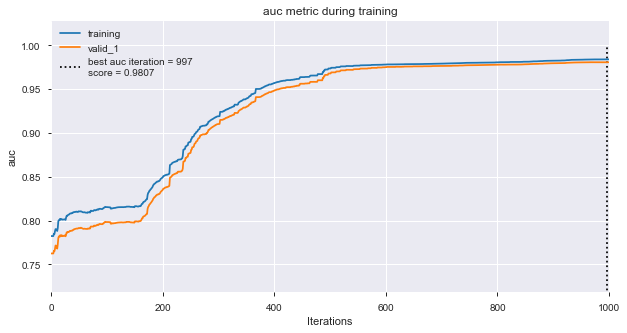

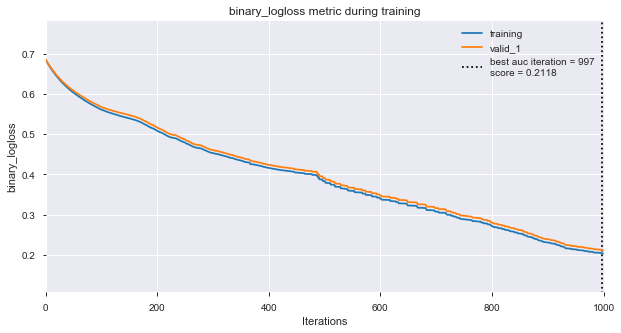

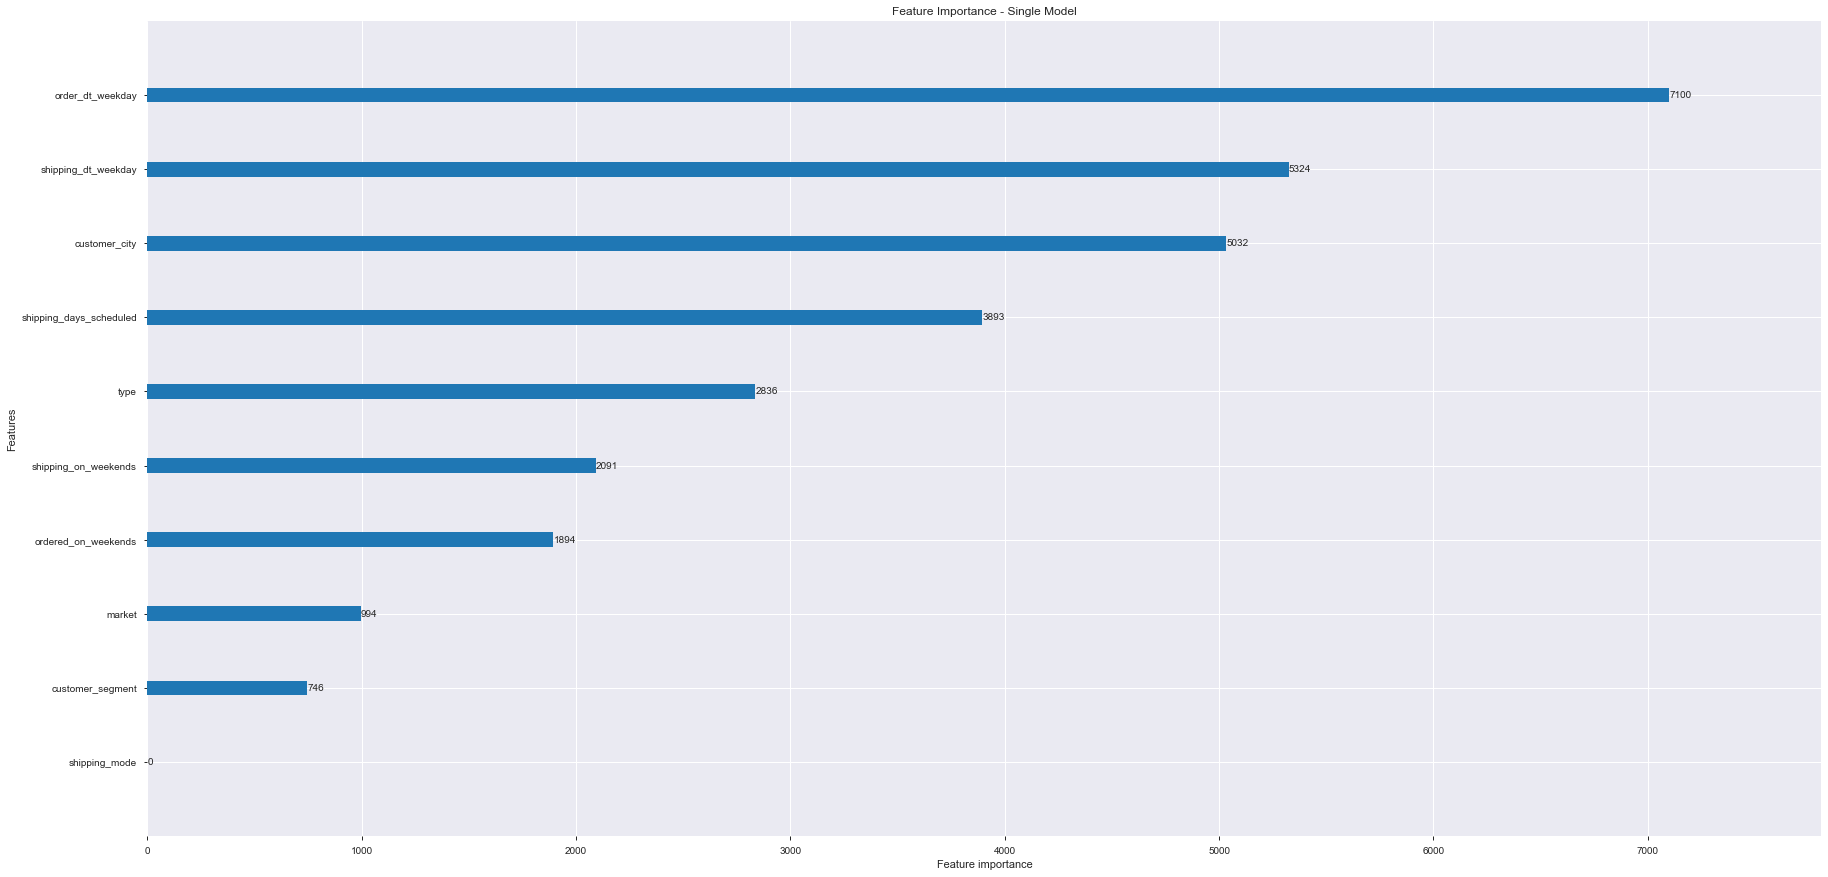

In [70]:
for metric in lgb_params['metric']:
    lgb.plot_metric(
        evals_result, figsize=(10, 5), 
        metric = metric,
        title = '{} metric during training'.format(metric),
    )
    plt.vlines(model.best_iteration, 
               0, 1, linestyles = 'dotted',
               label = 'best auc iteration = {}\nscore = {:.4f}'.format(
                   model.best_iteration, 
                   model.best_score['valid_1'][metric]))
    plt.legend()
    plt.show()

lgb.plot_importance(model, figsize=(30, 15), ignore_zero = False, )
plt.title('Feature Importance - Single Model');

# <a id='8'> 8.Predictions  </a>
#### <a href='#0'>Go To Top</a>

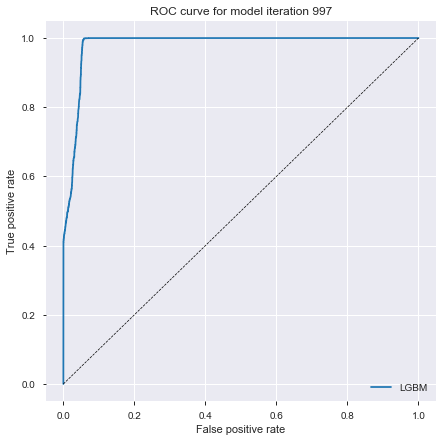

In [71]:
# build a quick ROC plot for the best model
from sklearn.metrics import roc_curve

y_hat_val = model.predict(
    X_val
)
fpr_grd, tpr_grd, _ = roc_curve(y_val, y_hat_val)

plt.figure(figsize = (7, 7))
plt.plot(fpr_grd, tpr_grd, label='LGBM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for model iteration ' + str(model.best_iteration))
plt.legend(loc='best')
plt.plot([0, 1], [0, 1], 'k--', linewidth = '0.7')
plt.show()

In [72]:
from sklearn.metrics import roc_auc_score

roc_auc_score(
   y_val, y_hat_val
)

0.9807056051587303

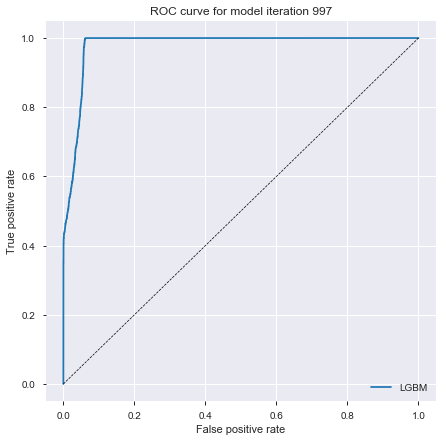

In [73]:
# build a quick ROC plot for the best model
from sklearn.metrics import roc_curve

y_hat = model.predict(
    X_test
)
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_hat)

plt.figure(figsize = (7, 7))
plt.plot(fpr_grd, tpr_grd, label='LGBM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for model iteration ' + str(model.best_iteration))
plt.legend(loc='best')
plt.plot([0, 1], [0, 1], 'k--', linewidth = '0.7')
plt.show()

In [74]:
from sklearn.metrics import roc_auc_score

roc_auc_score(
   y_test, y_hat
)

0.9788865129012583

In [75]:
#Print model report:
from sklearn.metrics import accuracy_score, log_loss, roc_curve,f1_score,confusion_matrix

In [76]:
y_hat_round = round(pd.DataFrame(y_hat))
print ("\nModel Report")
accuraryScore = accuracy_score(y_test, y_hat_round)
print("Accuracy: {:.2%}".format(accuraryScore))


Model Report
Accuracy: 97.08%


In [77]:
# Experimenting with LogLoss
logLoss = log_loss(y_test, y_hat)
#print("Log Loss: {:.2%}".format(logLoss))
print("Log Loss: {:5.2f}".format(logLoss))

Log Loss:  0.22


In [78]:
f1Score = f1_score(y_test, y_hat_round) # calculating f1 score
print("f score : {:.2%}".format(f1Score))
print("="*30)

f score : 97.39%


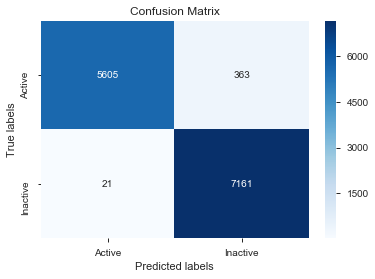

In [79]:
labels = [0, 1]
confusion_mat = confusion_matrix(y_test, y_hat_round,labels)
ax= plt.subplot()
sns.heatmap(confusion_mat, annot=True, ax = ax,fmt='g',cmap=plt.cm.Blues); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Active', 'Inactive']); ax.yaxis.set_ticklabels(['Active', 'Inactive']);ax= plt.subplot()
plt.show()

In [80]:
confusion_mat

array([[5605,  363],
       [  21, 7161]], dtype=int64)

Feature Importance ranking
Train dataset


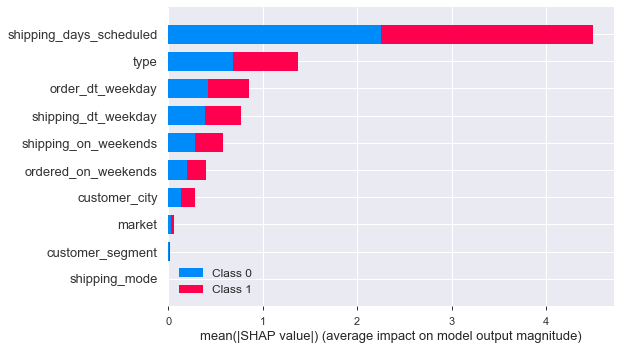

Test dataset


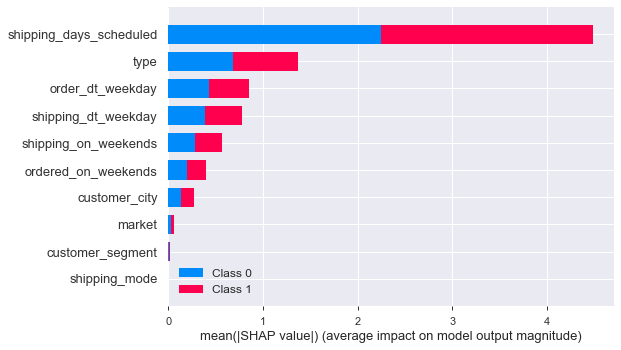

In [81]:
#%%time
# # 40.1 s

import shap

#load JS visualization code to notebook
shap.initjs()

explainer = shap.TreeExplainer(model)

print('Feature Importance ranking')
print('Train dataset')
shap_values_train = explainer.shap_values(
     X_train
)

shap.summary_plot(
     shap_values_train,     
     X_train,
     plot_type = "bar",
)

print('Test dataset')
shap_values_test = explainer.shap_values(
     X_test
)

shap.summary_plot(
     shap_values_test,     
     X_test,
     plot_type = "bar",
)

### With few additional  Attributes (Donot execute the below block)

Feature Importance ranking
Train dataset


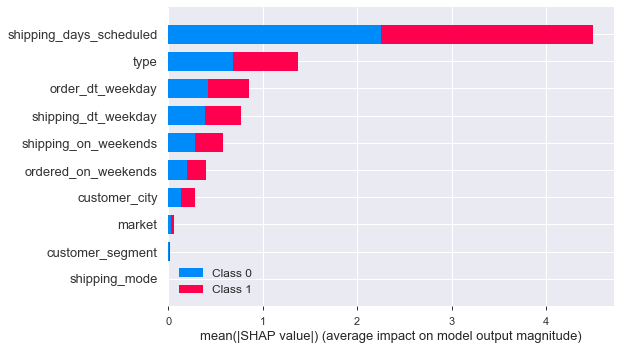

Test dataset


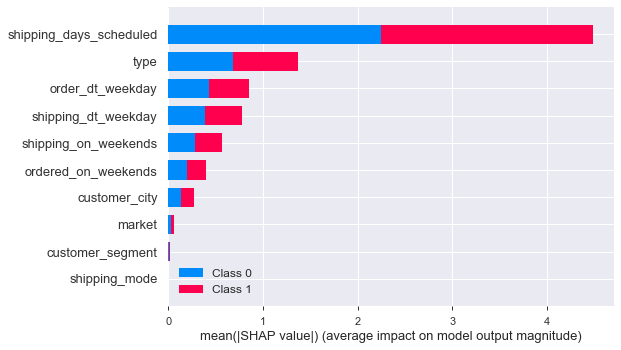

In [82]:
#%%time
# # 40.1 s

import shap

#load JS visualization code to notebook
shap.initjs()

explainer = shap.TreeExplainer(model)

print('Feature Importance ranking')
print('Train dataset')
shap_values_train = explainer.shap_values(
     X_train
)

shap.summary_plot(
     shap_values_train,     
     X_train,
     plot_type = "bar",
)

print('Test dataset')
shap_values_test = explainer.shap_values(
     X_test
)

shap.summary_plot(
     shap_values_test,     
     X_test,
     plot_type = "bar",
)

In [83]:
#Done!